## Third set of test runs - basic simulations, sparse fields where there is a mismeasurement of the PSFs (in terms of FWHM/shape/sigma).

Let's keep increasing the mismeasurement (percentage-wise) until we break ZOGY.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

2


From version "Copy5", it seems that around a 5.5% difference between the input PSF and the "measured" PSF is enough to break ZOGY. Let's take a look at what that actually means.

(0.040776220254577049, 17.126097761280946, -74.0, 1713.7774843356319)
(0.15886556420021791, 17.203687502780589, -82.0, 1131.5017745269811)
(300.04077622025449, 17.126097761280946, 226.0, 2013.7774843356319)
(300.15886556420025, 17.203687502780589, 218.0, 1431.5017745269811)
1.0 1.0


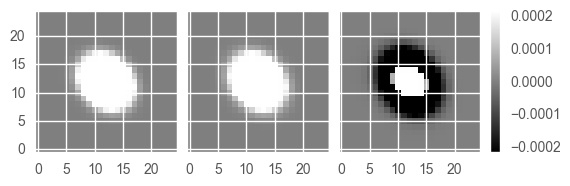

In [2]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.
breakLimit = 1.050

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

# Tweak the saved PSFs so the science PSF sigma is slightly wrong ("mis-measured"):
P_n = testObj.im2.psf
testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[1.8*breakLimit,2.2*breakLimit], theta=-45.*breakLimit)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

print P_n.sum(), testObj.im2.psf.sum()
dit.plotImageGrid((P_n, testObj.im2.psf, P_n-testObj.im2.psf))

In [3]:
print testObj.runTest()

#testObj.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1)
D_ZOGY = testObj.doZOGY(inImageSpace=False)
testObj.doZOGY(inImageSpace=True)
res = testObj.doALInStack()

{'ZOGY': {'FP': 18, 'FN': 0, 'TP': 3}, 'ALstack': {'FP': 0, 'FN': 0, 'TP': 3}, 'SZOGY': {'FP': 4, 'FN': 1, 'TP': 2}, 'ALstack_noDecorr': {'FP': 0, 'FN': 0, 'TP': 3}}


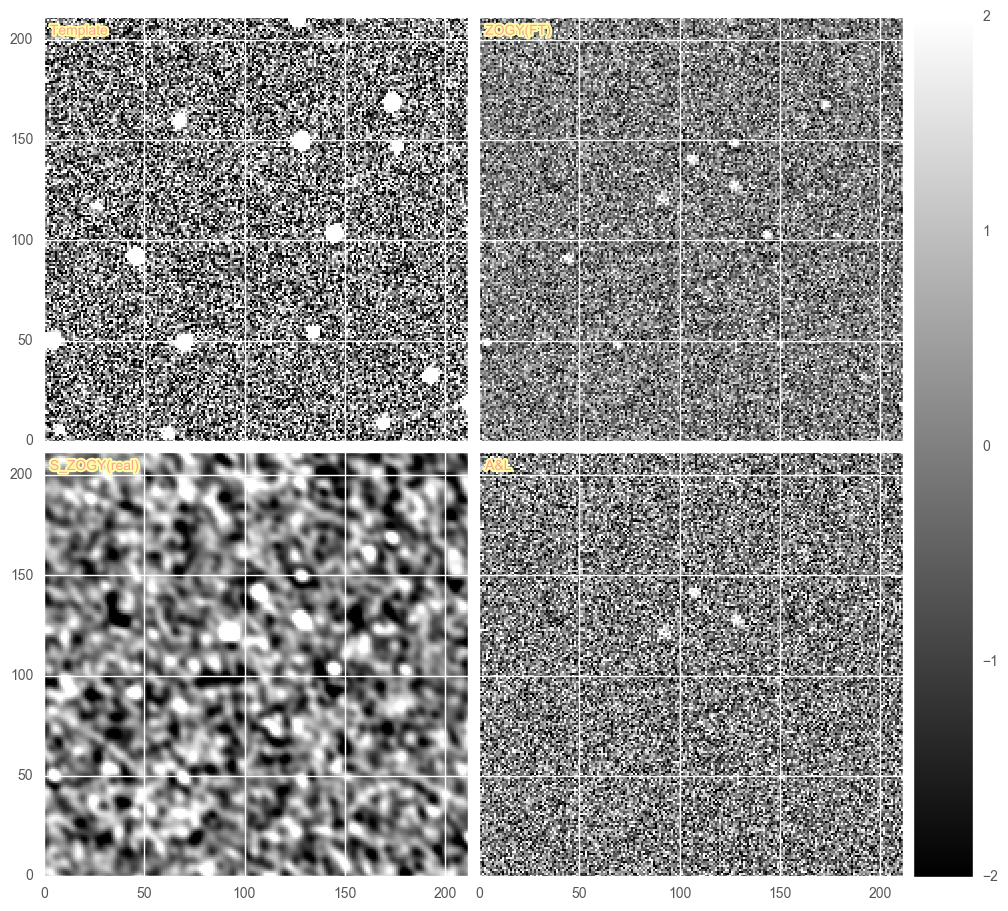

In [4]:
xim = np.arange(-256, 256, 1)
yim = xim.copy()

D_stack = res.decorrelatedDiffim.getMaskedImage().getImage().getArray()

fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
extent = (xim.min()+150, xim.max()-150, yim.min()+150, yim.max()-150)
dit.plotImageGrid((testObj.im1.im[x1d:x2d,y1d:y2d]/10., 
                   D_ZOGY.im[x1d:x2d,y1d:y2d], 
                   testObj.S_corr_ZOGY.im[x1d:x2d,y1d:y2d], 
                   #testObj.D_AL.im[x1d:x2d,y1d:y2d]), 
                   D_stack[x1d:x2d,y1d:y2d]/20.),
                  clim=(-2,2), titles=['Template', 'ZOGY(FT)', 'S_ZOGY(real)', 'A&L'])

See what happens if there's astrometric scintillation noise... even a little.

In [18]:
reload(dit)
testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         scintillation=0.2,
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

# Tweak the saved PSFs so the science PSF sigma is slightly wrong ("mis-measured"):
P_n = testObj.im2.psf
testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[1.8*breakLimit,2.2*breakLimit], theta=-45.*breakLimit)
print testObj.astrometricOffsets

[0.15981959012863711, 0.17918362841093344]


In [19]:
print testObj.runTest()

#testObj.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1)
D_ZOGY = testObj.doZOGY(inImageSpace=False)
testObj.doZOGY(inImageSpace=True)
res = testObj.doALInStack()

{'ZOGY': {'FP': 37, 'FN': 0, 'TP': 3}, 'ALstack': {'FP': 25, 'FN': 0, 'TP': 3}, 'SZOGY': {'FP': 0, 'FN': 0, 'TP': 3}, 'ALstack_noDecorr': {'FP': 26, 'FN': 0, 'TP': 3}}


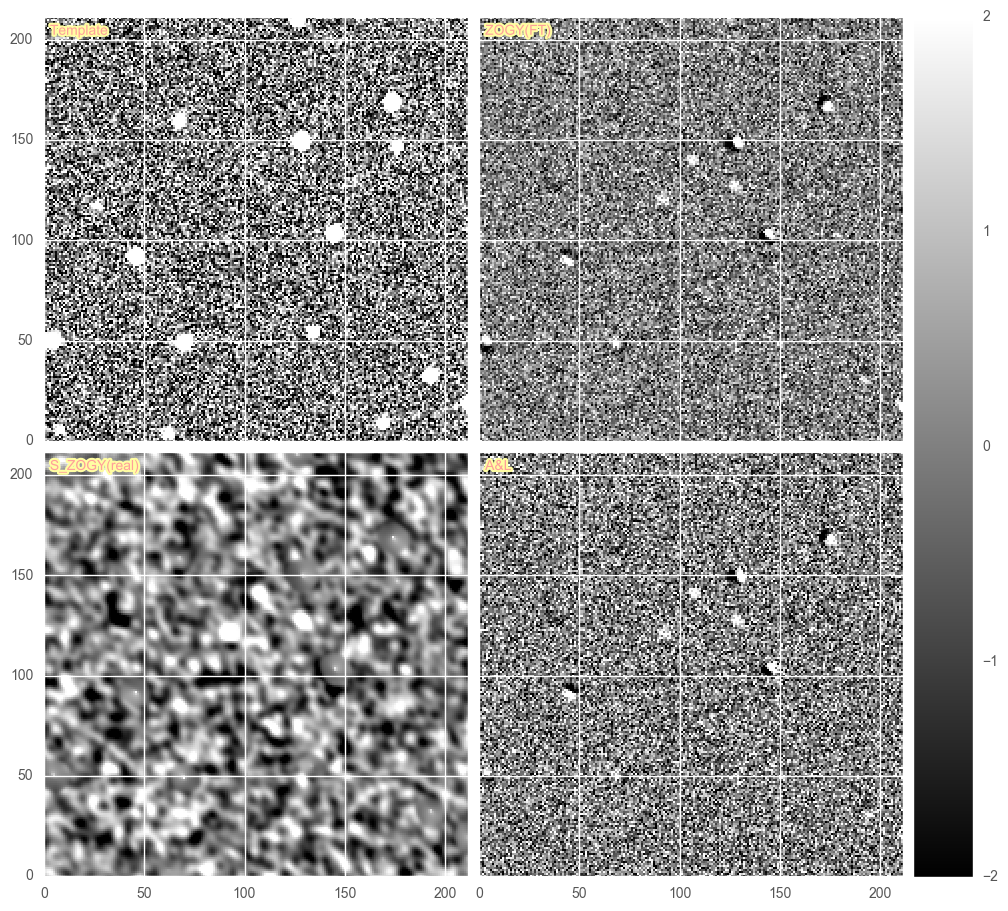

In [20]:
xim = np.arange(-256, 256, 1)
yim = xim.copy()

D_stack = res.decorrelatedDiffim.getMaskedImage().getImage().getArray()

fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
extent = (xim.min()+150, xim.max()-150, yim.min()+150, yim.max()-150)
dit.plotImageGrid((testObj.im1.im[x1d:x2d,y1d:y2d]/10., 
                   D_ZOGY.im[x1d:x2d,y1d:y2d], 
                   testObj.S_corr_ZOGY.im[x1d:x2d,y1d:y2d], 
                   #testObj.D_AL.im[x1d:x2d,y1d:y2d]), 
                   D_stack[x1d:x2d,y1d:y2d]/20.),
                  clim=(-2,2), titles=['Template', 'ZOGY(FT)', 'S_ZOGY(real)', 'A&L'])